[View in Colaboratory](https://colab.research.google.com/github/dexterfichuk/U-Net-Keras-Implementation/blob/master/U-Net%20Implementation.ipynb)

# Technical Paper Review: U-Net: Convolutional Networks for Biomedical Image Segmentation
*Dexter Fichuk*

The U-Net architecture is considered the standard of image segmentation for medical images. With variations winning numerous image segmentation Kaggle competitions, it is an extremely powerful architecture. It shines for training on small sets of data, where it's not easy to get many labeled images. This holds especially true for the medical discipline. The network relies heavily on the use of data augmentation to generate additional training data for the network and to prevent it from overfitting to a small training set. 

For this paper review, I wanted to implement the architecture described in the [original publication](https://arxiv.org/pdf/1505.04597.pdf). I'll be training the network on Google Colab, to leverage a high power GPU, instead of my MacBooks measly CPU. 

The architecture from the paper is visualized in the diagram below, and using this we will construct the network.
![U-Net Architecture](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png =600x)
## Image Segmentation
Image segmentation is used in various fields, but it is creating a model that can draw the masks of certain objects in an image, instead of simply predicting which class the iamge belongs to. It means that for training data, you must have the input image, then a masked version of the input image where each pixel of the input is represented with the class that pixel belongs.

## Data Description
To evaluate our U-Net, I'll be training it on a set of blood vessels segmented in retina images. To really push the network, I'll be using only 15 images for the training set and 5 for our testing set. The preview of the train/test sets can be found [here](http://cecas.clemson.edu/~ahoover/stare/probing/index.html).

## Setup for Google Colab
Since Google Colab restarts the runtime every 12 hours, we'll put all the code in here we need to install additional libraries, and load in the data properly.

In [0]:
!rm -rf *


In [0]:
!pip install -q keras tqdm scikit-image

Now we'll download our training data from http://cecas.clemson.edu/~ahoover/stare/probing/index.html, and unzip it to the proper directories that the code relies on.

In [3]:
!wget http://cecas.clemson.edu/~ahoover/stare/probing/stare-images.tar http://cecas.clemson.edu/~ahoover/stare/probing/labels-ah.tar

--2018-06-12 22:34:19--  http://cecas.clemson.edu/~ahoover/stare/probing/stare-images.tar
Resolving cecas.clemson.edu (cecas.clemson.edu)... 130.127.200.74
Connecting to cecas.clemson.edu (cecas.clemson.edu)|130.127.200.74|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18674176 (18M) [application/x-tar]
Saving to: ‘stare-images.tar’

stare-images.tar    100%[===================>]  17.81M  34.2MB/s    in 0.5s    

2018-06-12 22:34:20 (34.2 MB/s) - ‘stare-images.tar’ saved [18674176/18674176]

--2018-06-12 22:34:20--  http://cecas.clemson.edu/~ahoover/stare/probing/labels-ah.tar
Reusing existing connection to cecas.clemson.edu:80.
HTTP request sent, awaiting response... 200 OK
Length: 241664 (236K) [application/x-tar]
Saving to: ‘labels-ah.tar’

labels-ah.tar       100%[===================>] 236.00K  --.-KB/s    in 0.003s  

2018-06-12 22:34:20 (78.8 MB/s) - ‘labels-ah.tar’ saved [241664/241664]

FINISHED --2018-06-12 22:34:20--
Total wall clock time: 0.7s
Downl

The following code makes the required directories, and then unzips all of out data.

In [0]:
!mkdir -p data/retina/input
!mkdir -p data/retina/masks

In [0]:
!tar -xf labels-ah.tar -C data/retina/masks/
!tar -xf stare-images.tar -C data/retina/input/

In [0]:
!find data/retina/input/ -name '*.gz' -exec gunzip '{}' \;
!find data/retina/masks/ -name '*.gz' -exec gunzip '{}' \;

In [7]:
!ls data/retina/masks

im0001.ah.ppm  im0005.ah.ppm  im0082.ah.ppm  im0235.ah.ppm  im0255.ah.ppm
im0002.ah.ppm  im0044.ah.ppm  im0139.ah.ppm  im0236.ah.ppm  im0291.ah.ppm
im0003.ah.ppm  im0077.ah.ppm  im0162.ah.ppm  im0239.ah.ppm  im0319.ah.ppm
im0004.ah.ppm  im0081.ah.ppm  im0163.ah.ppm  im0240.ah.ppm  im0324.ah.ppm


In [8]:
!ls data/retina/input

im0001.ppm  im0005.ppm	im0082.ppm  im0235.ppm	im0255.ppm
im0002.ppm  im0044.ppm	im0139.ppm  im0236.ppm	im0291.ppm
im0003.ppm  im0077.ppm	im0162.ppm  im0239.ppm	im0319.ppm
im0004.ppm  im0081.ppm	im0163.ppm  im0240.ppm	im0324.ppm


In [9]:
!ls

data  labels-ah.tar  stare-images.tar


In [0]:
!rm -rf labels-ah.tar stare-images.tar

## Implementation

To implement the U-Net, I'm going to use Keras because it is powerful, and I the fastest way for me to create it. 

In [11]:
# Layes to be used
from keras.layers import Conv2D, MaxPool2D, UpSampling2D, merge, Input, Cropping2D, Dropout, Lambda

# For residual connection
from keras.layers.merge import concatenate
from keras.optimizers import *
from keras.models import *
import keras.backend as K

# Loss function to possibly be used, but bce dice also good
from keras.losses import binary_crossentropy

Using TensorFlow backend.


### Metrics
Unlike a normal binary prediction where we use binary_crossentropy for loss and accuracy for our metric, we need to use some alternate metrics. This is because instead of prediciton a single output variable, we are predicting an output class for every single pixel (image segmentation). To evaluate the model, we'll use the following custom metrics:
- BCE Dice Loss used as loss function.
- Jaccard Coefficient used to calculate intersection over union (accuracy)

In [0]:

smooth = 1e-12

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score
  
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def jaccard_coef(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)

### Model
Using the dagram from the U-Net paper, we'll implement the same architecture with identical parameters.

In [0]:
# To be changed if needing to crop network for different sized images
# TODO finish implementing 
pad = 'same'

In [0]:
# TODO implement down and upsamples into functions
def create_unet(lr = 1e-4, width = 256, height = 256):
  # First downsampling block
  # 64 filters for output
  # filter size of 3 specifies a 3x3 sliding convolution window
  # he_normal used to initialize gaussian distributed random weights (recommended form U-Net paper)
  
  inputs = Input(shape=(width, height, 3))
  # This lambda scales the input from the RGB range of 0-255, to be between 0 and 1.
  s = Lambda(lambda x: x / 255) (inputs)
  
  # first conv layers
  conv1 = Conv2D(64, 3, activation = 'relu', padding=pad, kernel_initializer='he_normal') (s)
  conv1 = Conv2D(64, 3, activation = 'relu', padding=pad, kernel_initializer='he_normal') (conv1)

  # Downsampling
  pool1 = MaxPool2D(pool_size=(2,2), padding=pad) (conv1)
  
  # Second downsampling block
  conv2 = Conv2D(128, 3, activation='relu', padding=pad, kernel_initializer='he_normal') (pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding=pad, kernel_initializer='he_normal') (conv2)
  pool2 = MaxPool2D(pool_size=(2, 2), padding = pad) (conv2)

  # Third downsampling block
  conv3 = Conv2D(256, 3, activation='relu', padding=pad, kernel_initializer='he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding=pad, kernel_initializer='he_normal')(conv3)
  pool3 = MaxPool2D(pool_size=(2, 2), padding=pad) (conv3)

  # Fourth downsampling block
  conv4 = Conv2D(512, 3, activation='relu', padding=pad, kernel_initializer='he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding=pad, kernel_initializer='he_normal')(conv4)

  # Dropout added to final downsamples
  drop4 = Dropout(0.0)(conv4)
  pool4 = MaxPool2D(pool_size=(2, 2), padding=pad) (drop4)

  conv5 = Conv2D(1024, 3, activation='relu', padding=pad, kernel_initializer='he_normal')(pool4)
  conv5 = Conv2D(1024, 3, activation='relu', padding=pad, kernel_initializer='he_normal')(conv5)
  # Final dropout
  drop5 = Dropout(0.0)(conv5)


  # Upsample 1
  up1 = UpSampling2D(size=(2, 2)) (drop5)
  up1 = concatenate([conv4, up1], axis=3)
  upconv1 = Conv2D(512, 3, activation='relu', padding=pad, kernel_initializer='he_normal')(up1)
  upconv1 = Conv2D(512, 3, activation='relu', padding=pad, kernel_initializer='he_normal')(upconv1)

  up2 = UpSampling2D(size=(2, 2)) (upconv1)
  up2 = concatenate([conv3, up2], axis=3)
  upconv2 = Conv2D(256, 3, activation='relu', padding=pad, kernel_initializer='he_normal')(up2)
  upconv2 = Conv2D(256, 3, activation='relu', padding=pad, kernel_initializer='he_normal')(upconv2)

  up3 = UpSampling2D(size=(2, 2)) (upconv2)
  up3 = concatenate([conv2, up3], axis=3)
  upconv3 = Conv2D(128, 3, activation='relu', padding=pad, kernel_initializer='he_normal')(up3)
  upconv3 = Conv2D(128, 3, activation='relu', padding=pad, kernel_initializer='he_normal')(upconv3)

  up4 = UpSampling2D(size=(2, 2)) (upconv3)
  up4 = concatenate([conv1, up4], axis=3)
  upconv4 = Conv2D(64, 3, activation='relu', padding=pad, kernel_initializer='he_normal')(up4)
  upconv4 = Conv2D(64, 3, activation='relu', padding=pad, kernel_initializer='he_normal')(upconv4)

  outconv = Conv2D(1, 1, activation='sigmoid')(upconv4)
  
  model = None
  model = Model(inputs = inputs, outputs = outconv)
  model.compile(optimizer=Adam(lr = lr), loss=bce_dice_loss, metrics=[jaccard_coef])
  return model

Now let's print a summary of our U-Net model! This can be super useful for debugging the model when training, getting an idea of the output dimensionality of each layer, and seeing where layers are joined together.

In [82]:
create_unet().summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, 256, 256, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_134 (Conv2D)             (None, 256, 256, 64) 1792        lambda_8[0][0]                   
__________________________________________________________________________________________________
conv2d_135 (Conv2D)             (None, 256, 256, 64) 36928       conv2d_134[0][0]                 
__________________________________________________________________________________________________
max_poolin

Our model has over a whopping 30 million parameters to train! It's fair to say this is a very deep neural network that would be nearly impossible to train on a CPU based machine.

## Loading Data
The dataset we'll be using is a segmentation set for the blood vessel's in a retina. To really bush the boundaries of a U-Net, I'm only going to train the model on 15 training images, the complete opposite of big data. We'll then use 5 images for our validation dataset. The claim in the paper is that through using data augmentation, and the u-net architecture, we shoudl be able to train a high quality model!

In [0]:
import numpy as np
import os
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
import tqdm
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Our seed to keep our models results reproducable
seed = 42

# Get the ID's of all the images by walking through the directory
train_ids = next(os.walk('data/retina/input'))[2]
train_ids = [i.replace(".ppm", "") for i in train_ids]

In [0]:
# Set the dimensions for our images to be resized to, most are square so this is good
width, height = 256, 256

In [0]:
# Load in the images and masks, and then resize them to our defined dimensions
X, y = [], []

for id_ in train_ids:
#     path = TRAIN_PATH + id_
    # Read in the image
    img = imread('data/retina/input/' + id_ + '.ppm')[:,:,:3]
    img = resize(img, (height, width), mode='constant', preserve_range=True)
    X.append(img)
    
    mask = np.zeros((height, width, 1), dtype=np.bool)
    
    mask_ = imread('data/retina/masks/' + id_ + ".ah.ppm")
    mask_ = np.expand_dims(resize(mask_, (height, width), mode='constant'), axis=-1)
    mask = np.maximum(mask, mask_)
    y.append(mask)

X, y = np.asarray(X), np.asarray(y)

Now we'll preview the what an input image looks like, and it's corresponding mask.

Input Image


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


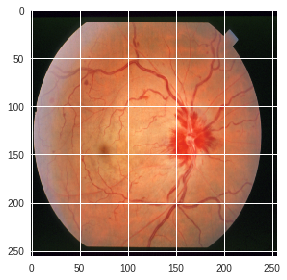

Target Mask


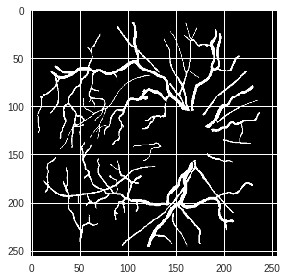

In [86]:
# Check if training data looks okay
print("Input Image")
ix = random.randint(0, len(train_ids)-1)
imshow(X[ix]/255)
plt.show()
print("Target Mask")
imshow(np.squeeze(y[ix]))
plt.show()

You can tell that since we've reduced the images from their original size of 700x605 to 256x256 we've lost a bit of the lines. However, this is a fair tradeoff as our model will have a much faster time training on these smaller images. Since we're also resizing all the images to the same size, we don't have to worry about adding special cropping to our U-Net architecture, although it is capable of handling training images of different sizes.

In [87]:
# Split our data into training and testing sets
X_train, X_test, y_train, y_test = X[:15], X[15:], y[:15], y[15:]
print("Num Train:", len(X_train))
print("Num Test:", len(X_test))

Num Train: 15
Num Test: 5


## Data Augmentation
The U-Net is optimized for data augmentation, as highlighted in the paper. So we will define a image data generator that will perform multiple transformations to out training data. Using keras built-in ImageDataGenerator, we can set different transformations that the model will randomly perform to our training data to create more. This is used for improving the model, and it highly decreases the chances of overfitting because the model is constantly seeing different examples. For our generator, we'll apply some simple transformations, allowing the zoom range to be 20% of the original image, the sheet range to also be 20%, and we'll allow the images to be flipped horizontal.

### Custom Augmentations

While the Keras ImageDataGenerator is powerful, it can be difficult to extend. One way is to recreate the entire class and add your functions, and the other is to pass in a pre_processing function. The downside of the pre_processing function is that it uses the augmentation on each of the images. I wanted to create 2 custom augmentations that ar known to be effective in medical image training, but only apply it to a random percentage of augmentations. 

The workaround I came up with is to write a single function that takes the probability for each of the following, and then will only use the function for that augmentation randomly the specified probability.

In [0]:
from skimage import data, img_as_float, exposure, io
import random

'''
Histogram Equalization increases contrast in images by detecting the distribution 
of pixel densities in an image and plotting these pixel densities on a histogram. 
'''
def equalize_hist(img):
  return exposure.equalize_hist(img)*255

'''
Adaptive Equalization has a tendency to over-amplify noise in otherwise uninteresting sections
'''
def adaptive_equalization(img):
  return exposure.equalize_adapthist(img/255., clip_limit=0.03)*255

def custom_augmentations(img, prob = 0.2):
  # Scaleup the prob
  prob = prob*100
  # Generate a random int between 0 and 100, then see if it's between 0 and our probability
  if random.randint(0,100) <= prob:
    img = equalize_hist(img)
  # Try again to see if we shoudl apply the other.
  elif random.randint(0,100) <= prob:
    img = adaptive_equalization(img) 
  return img

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


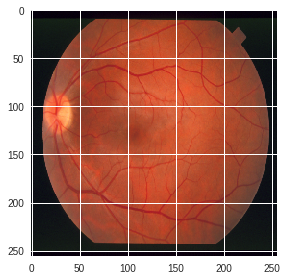

In [89]:
# Testing the method
imshow(custom_augmentations(X_train[0])/255.)

#### Original

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


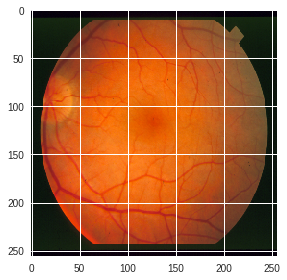

In [90]:
imshow(img_as_float(X_train[2]/255.))

#### Equalize Histogram

/usr/local/lib/python3.6/dist-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "
/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


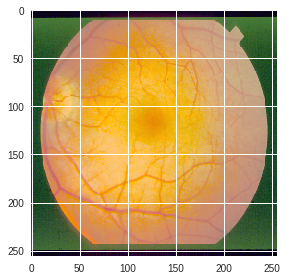

In [91]:
imshow(equalize_hist(X_train[2])/255.)

#### Adaptive Equalization

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


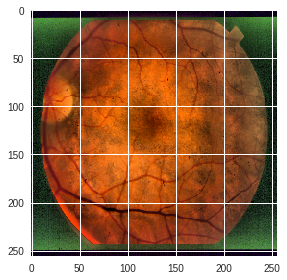

In [92]:
imshow(adaptive_equalization(X_train[2])/255.)

## Data Generator

In [0]:
from keras.preprocessing.image import ImageDataGenerator

# Define our transformations
train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        preprocessing_function=custom_augmentations)

mask_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)


BATCH_SIZE = 6

# Keep the same seed for image and mask generators so they fit together

train_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)

X_gen = train_datagen.flow(X_train,batch_size=BATCH_SIZE, seed=seed)
y_gen = mask_datagen.flow(y_train,batch_size=BATCH_SIZE, seed=seed)


In [0]:
#creating a training and validation generator that generate masks and images
train_generator = zip(X_gen, y_gen)

Now that our data generator is fitted to our training data, let's preview some of the variants it creates.

/usr/local/lib/python3.6/dist-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


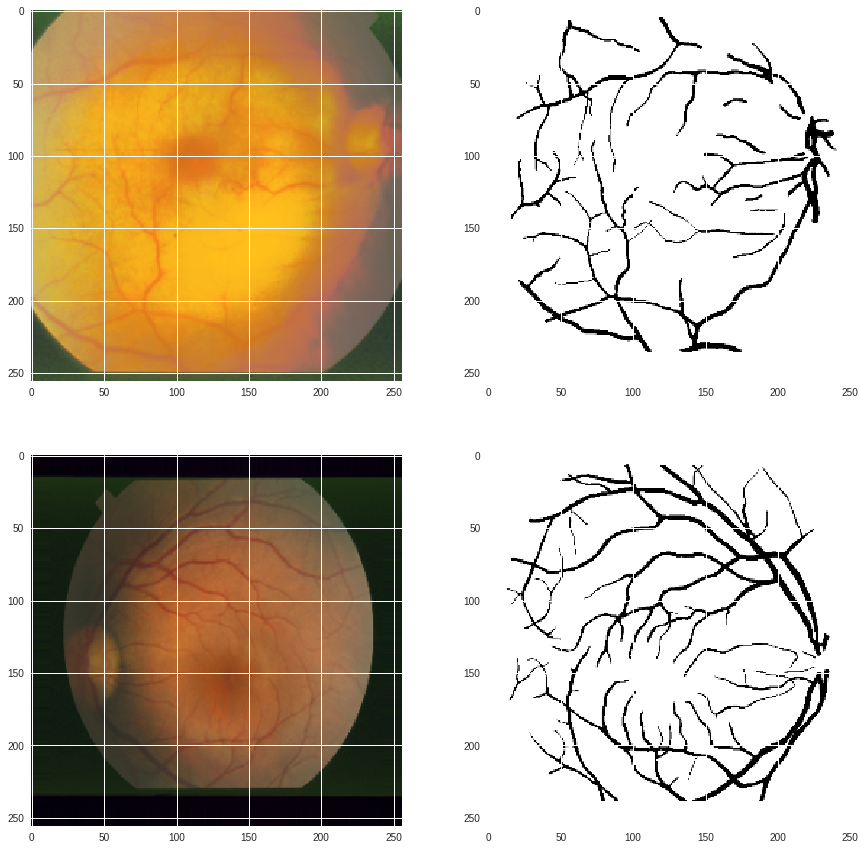

In [95]:
# Print some generated images
for X_batch, y_batch in train_datagen.flow(X_train, y_train, batch_size=9):
	# create a grid of 3x3 images
  f, axarr = plt.subplots(2,2,figsize=(15,15))
  for i in range(0, 2):
    axarr[i,0].imshow(X_batch[i]/255) 
    axarr[i,1].imshow(np.squeeze(y_batch[i]))
#     plt.show()
  break

Great, everything looks good with these images so it's time to move onto our training!

## Training

We'll first load in an instance of our model.

In [0]:
model = create_unet()

Now I'm going to add 3 different callbacks to our model. Callbacks are functions that are run after each epoch of training, and can influence the future training of our model. The callbacks work as follows:
- The EarlyStopper can terminate our model earlier than our full set number of epochs. All we have to do is set the patience to a number, and if the validation loss hasn't improved in that many epochs, our training will terminate as we're likely overfitting.
- The ModelCheckpoint will save the weights of our model after each epoch if the validation loss has improved. This means, even if we've continued to train our model and overfit it, we'll only save the last copy that had improved the validation loss, which can then be loaded in afterwards. This allows us to set a higher patience for the early stopper because we know even if we overfit, we'll just load back the best val weights.
- Lastly, the ReduceLROnPlateau will reduce the models learning rate by a set factor if the validation loss hasn't increased in a certain number of epochs. Typically, when a model is starting to reach it's highest achievable accuracy, reducing the learning rate can help make more fine tuned changes without damaging the model.

In [97]:
# Tensorboard Utils
!wget https://raw.githubusercontent.com/Zahlii/colab-tf-utils/master/utils.py
import utils
import os

--2018-06-12 23:49:36--  https://raw.githubusercontent.com/Zahlii/colab-tf-utils/master/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6935 (6.8K) [text/plain]
Saving to: ‘utils.py.3’

utils.py.3          100%[===================>]   6.77K  --.-KB/s    in 0s      

2018-06-12 23:49:36 (71.0 MB/s) - ‘utils.py.3’ saved [6935/6935]



In [98]:
!wget https://raw.githubusercontent.com/bckenstler/CLR/master/clr_callback.py

--2018-06-12 23:49:38--  https://raw.githubusercontent.com/bckenstler/CLR/master/clr_callback.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5326 (5.2K) [text/plain]
Saving to: ‘clr_callback.py.2’

clr_callback.py.2   100%[===================>]   5.20K  --.-KB/s    in 0s      

2018-06-12 23:49:38 (53.8 MB/s) - ‘clr_callback.py.2’ saved [5326/5326]



I also chose to use Cyclical Learning Rates, a lesser known method for setting the LR that has been shows to help networks converge faster.

In [0]:
from clr_callback import *

clr_triangular = CyclicLR(mode='exp_range', gamma=0.99994)

In [0]:
# Callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

# Fit model
earlystopper = EarlyStopping(patience=12, verbose=1)

checkpointer = ModelCheckpoint('model-retina-unet.h5', verbose=2, save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.00005, verbose = 1)

tb = TensorBoard(log_dir=os.path.join(utils.LOG_DIR,'U-Net'))

Fianlly, we'll train our model with keras fit_generator. The fit_generator allows us to use our data generator for training. We'll then do a low number of steps_per_epoch because we're only generating 6 images for each epoch. We'll then allow our model to train for 100 epochs, and at the end of each epoch have it evaluate on the testing set of data. We don't want to apply any augmentations to our test set because we want it to be the same consisten set for each epoch.

In [101]:
model.fit_generator(train_generator, steps_per_epoch=15, epochs = 100, 
                    validation_data=(X_test, y_test), verbose=1,
                    callbacks=[earlystopper, checkpointer, reduce_lr, tb, clr_triangular])

Epoch 1/100


/usr/local/lib/python3.6/dist-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


15/15 [==============================] - 15s 979ms/step - loss: 2.1090 - jaccard_coef: 0.0407 - val_loss: 1.4369 - val_jaccard_coef: 0.0046

Epoch 00001: val_loss improved from inf to 1.43687, saving model to model-retina-unet.h5
Epoch 2/100
15/15 [==============================] - 13s 867ms/step - loss: 1.1958 - jaccard_coef: 0.0569 - val_loss: 1.1145 - val_jaccard_coef: 0.0666

Epoch 00002: val_loss improved from 1.43687 to 1.11445, saving model to model-retina-unet.h5
Epoch 3/100
15/15 [==============================] - 13s 856ms/step - loss: 1.1087 - jaccard_coef: 0.0707 - val_loss: 1.0892 - val_jaccard_coef: 0.0698

Epoch 00003: val_loss improved from 1.11445 to 1.08916, saving model to model-retina-unet.h5
Epoch 4/100
15/15 [==============================] - 13s 859ms/step - loss: 1.1080 - jaccard_coef: 0.0750 - val_loss: 1.1065 - val_jaccard_coef: 0.0897

Epoch 00004: val_loss did not improve from 1.08916
Epoch 5/100
15/15 [==============================] - 13s 858ms/step - loss

15/15 [==============================] - 13s 858ms/step - loss: 1.1099 - jaccard_coef: 0.0832 - val_loss: 1.0429 - val_jaccard_coef: 0.0873

Epoch 00008: val_loss did not improve from 0.97186
Epoch 9/100
15/15 [==============================] - 13s 857ms/step - loss: 1.0756 - jaccard_coef: 0.0907 - val_loss: 0.9929 - val_jaccard_coef: 0.1055

Epoch 00009: val_loss did not improve from 0.97186

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0006673886091448367.
Epoch 10/100
15/15 [==============================] - 13s 858ms/step - loss: 1.0281 - jaccard_coef: 0.1054 - val_loss: 1.0218 - val_jaccard_coef: 0.1035

Epoch 00010: val_loss did not improve from 0.97186
Epoch 11/100
15/15 [==============================] - 13s 857ms/step - loss: 1.0318 - jaccard_coef: 0.1168 - val_loss: 2.0917 - val_jaccard_coef: 0.1090

Epoch 00011: val_loss did not improve from 0.97186
Epoch 12/100
15/15 [==============================] - 13s 857ms/step - loss: 1.1897 - jaccard_coef: 0.0786 - val_

15/15 [==============================] - 13s 858ms/step - loss: 0.9653 - jaccard_coef: 0.1426 - val_loss: 0.7937 - val_jaccard_coef: 0.2387

Epoch 00015: val_loss improved from 0.94914 to 0.79374, saving model to model-retina-unet.h5
Epoch 16/100
15/15 [==============================] - 13s 857ms/step - loss: 0.8778 - jaccard_coef: 0.2040 - val_loss: 0.7284 - val_jaccard_coef: 0.2678

Epoch 00016: val_loss improved from 0.79374 to 0.72840, saving model to model-retina-unet.h5
Epoch 17/100
15/15 [==============================] - 13s 857ms/step - loss: 0.7650 - jaccard_coef: 0.2559 - val_loss: 0.6329 - val_jaccard_coef: 0.3251

Epoch 00017: val_loss improved from 0.72840 to 0.63290, saving model to model-retina-unet.h5
Epoch 18/100
15/15 [==============================] - 13s 858ms/step - loss: 0.7454 - jaccard_coef: 0.2753 - val_loss: 0.5848 - val_jaccard_coef: 0.3522

Epoch 00018: val_loss improved from 0.63290 to 0.58476, saving model to model-retina-unet.h5
Epoch 19/100
15/15 [=====

15/15 [==============================] - 13s 857ms/step - loss: 0.6523 - jaccard_coef: 0.3473 - val_loss: 0.5173 - val_jaccard_coef: 0.4218

Epoch 00022: val_loss improved from 0.52657 to 0.51728, saving model to model-retina-unet.h5
Epoch 23/100
15/15 [==============================] - 13s 858ms/step - loss: 0.6828 - jaccard_coef: 0.3231 - val_loss: 0.4871 - val_jaccard_coef: 0.4285

Epoch 00023: val_loss improved from 0.51728 to 0.48712, saving model to model-retina-unet.h5
Epoch 24/100
15/15 [==============================] - 13s 857ms/step - loss: 0.6530 - jaccard_coef: 0.3447 - val_loss: 0.5152 - val_jaccard_coef: 0.4210

Epoch 00024: val_loss did not improve from 0.48712
Epoch 25/100
15/15 [==============================] - 13s 857ms/step - loss: 0.6482 - jaccard_coef: 0.3497 - val_loss: 0.5289 - val_jaccard_coef: 0.4174

Epoch 00025: val_loss did not improve from 0.48712
Epoch 26/100
15/15 [==============================] - 13s 858ms/step - loss: 0.6363 - jaccard_coef: 0.3608 - 

15/15 [==============================] - 13s 858ms/step - loss: 0.5919 - jaccard_coef: 0.3916 - val_loss: 0.4973 - val_jaccard_coef: 0.4349

Epoch 00029: val_loss did not improve from 0.47715
Epoch 30/100
15/15 [==============================] - 13s 857ms/step - loss: 0.5768 - jaccard_coef: 0.3984 - val_loss: 0.4558 - val_jaccard_coef: 0.4634

Epoch 00030: val_loss improved from 0.47715 to 0.45581, saving model to model-retina-unet.h5
Epoch 31/100
15/15 [==============================] - 13s 857ms/step - loss: 0.5527 - jaccard_coef: 0.4166 - val_loss: 0.4366 - val_jaccard_coef: 0.4614

Epoch 00031: val_loss improved from 0.45581 to 0.43660, saving model to model-retina-unet.h5
Epoch 32/100
15/15 [==============================] - 13s 857ms/step - loss: 0.5465 - jaccard_coef: 0.4230 - val_loss: 0.4486 - val_jaccard_coef: 0.4596

Epoch 00032: val_loss did not improve from 0.43660
Epoch 33/100
15/15 [==============================] - 13s 859ms/step - loss: 0.5608 - jaccard_coef: 0.4180 - 

15/15 [==============================] - 13s 860ms/step - loss: 0.6835 - jaccard_coef: 0.3747 - val_loss: 0.5802 - val_jaccard_coef: 0.3576

Epoch 00036: val_loss did not improve from 0.42076
Epoch 37/100
15/15 [==============================] - 13s 855ms/step - loss: 1.9255 - jaccard_coef: 0.0611 - val_loss: 2.2542 - val_jaccard_coef: 0.0711

Epoch 00037: val_loss did not improve from 0.42076
Epoch 38/100
15/15 [==============================] - 13s 852ms/step - loss: 2.2768 - jaccard_coef: 0.0085 - val_loss: 2.2542 - val_jaccard_coef: 0.0711

Epoch 00038: val_loss did not improve from 0.42076

Epoch 00038: ReduceLROnPlateau reducing learning rate to 0.0011885437415912747.
Epoch 39/100
15/15 [==============================] - 13s 852ms/step - loss: 2.2178 - jaccard_coef: 0.0343 - val_loss: 2.2542 - val_jaccard_coef: 0.0711

Epoch 00039: val_loss did not improve from 0.42076
Epoch 40/100
15/15 [==============================] - 13s 855ms/step - loss: 2.2223 - jaccard_coef: 7.9102e-04 -

15/15 [==============================] - 13s 853ms/step - loss: 2.2330 - jaccard_coef: 0.0134 - val_loss: 2.2542 - val_jaccard_coef: 0.0711

Epoch 00043: val_loss did not improve from 0.42076
Epoch 44/100
15/15 [==============================] - 13s 853ms/step - loss: 2.2046 - jaccard_coef: 0.0072 - val_loss: 2.2542 - val_jaccard_coef: 0.0711

Epoch 00044: val_loss did not improve from 0.42076

Epoch 00044: ReduceLROnPlateau reducing learning rate to 0.0012929674703627825.
Epoch 45/100
15/15 [==============================] - 13s 851ms/step - loss: 2.2372 - jaccard_coef: 0.0183 - val_loss: 2.2542 - val_jaccard_coef: 0.0711

Epoch 00045: val_loss did not improve from 0.42076
Epoch 46/100
15/15 [==============================] - 13s 853ms/step - loss: 2.2203 - jaccard_coef: 0.0158 - val_loss: 2.2542 - val_jaccard_coef: 0.0711

Epoch 00046: val_loss did not improve from 0.42076
Epoch 47/100
15/15 [==============================] - 13s 852ms/step - loss: 2.2052 - jaccard_coef: 0.0182 - val

We can see that our callbacks consistintly saves the models weights when val loss improved, it reduced the learning rate when their wasn't any improvements for a few epochs, and terminated early because it wasn't seeing any progress. We'll now load back in the last saved weights to have the best version of the model.

The standard threashold for the Jaccard coefficient to be considered accurate is if it is >= 0.5, as noted by Andrew Ng, where 1 is a perfect prediction. We can see from our model, the val_jaccard_coef typicall reaches 0.4817, which is extremely impressive for only having 15 training images.

In [0]:
from keras.models import load_model
# Have to load back in custom loss and metrics with the models weights
model = load_model("model-retina-unet.h5", custom_objects=({'bce_dice_loss': bce_dice_loss, 
                                                            'jaccard_coef': jaccard_coef}))

### Saving Model Weights to Google Drive
*Is a whopping 350MB*

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [42]:
f = drive.CreateFile()
f.SetContentFile('model-retina-unet.h5')
f.Upload()
print('title: %s, mimeType: %s' % (f['title'], f['mimeType']))

title: model-retina-unet.h5, mimeType: application/octet-stream


## Evaluation

Now, let's preview one of our models predictions against the actual labels using an image from our test set that the model was not trained on!

In [0]:
y_pred = model.predict(X_test)

Original Image


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


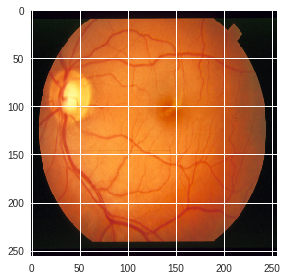

Ground Truth


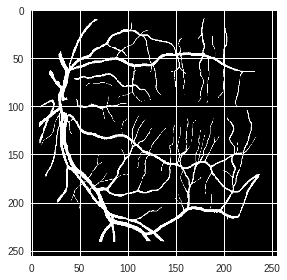

Prediction


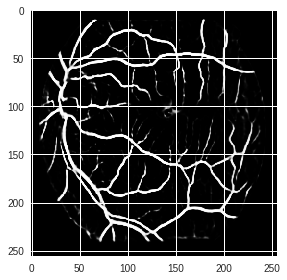

In [105]:
test_ind = 1

print("Original Image")
imshow(X_test[test_ind]/255)
plt.show()
print("Ground Truth")
imshow(np.squeeze(y_test[test_ind]))
plt.show()
print("Prediction")
imshow(np.squeeze(y_pred[test_ind]))
plt.show()

We'll try just anohter test image to play it safe.


Original Image


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


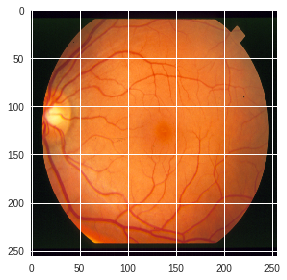

Ground Truth


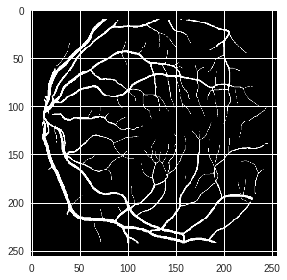

Prediction


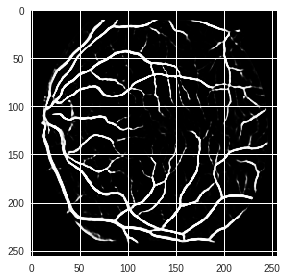

In [106]:
test_ind = 3

print("Original Image")
imshow(X_test[test_ind]/255)
plt.show()
print("Ground Truth")
imshow(np.squeeze(y_test[test_ind]))
plt.show()
print("Prediction")
imshow(np.squeeze(y_pred[test_ind]))
plt.show()

Interestingly enough, we can actually see that our model performs smoothing of the vessels compared to the shrunk target masks. But we can see how precise our U-net's predictions are!

## References
- https://arxiv.org/pdf/1505.04597.pdf
- http://cecas.clemson.edu/~ahoover/stare/probing/index.html
- https://towardsdatascience.com/image-augmentation-for-deep-learning-using-keras-and-histogram-equalization-9329f6ae5085
- https://www.cv-foundation.org/openaccess/content_cvpr_2015/app/2B_011.pdf
- https://arxiv.org/pdf/1506.01186.pdf
- https://github.com/bckenstler/CLR